In [7]:
import importlib
import my_functions

# Reload the module to reflect changes
importlib.reload(my_functions)

# Re-import the functions to update them
from my_functions import *

In [8]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*
#Open Zmumu file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Set event range
nmin1=0
nmax1=3000

#Choose quality 0
Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Open ZeroBias file
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/zbV3_skim.root") 
MuonTree_ZeroBias=file["MuonTree;1"]

#Apply energy cut to offline
ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())
ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())
ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())

#Get online data
Zbl1_pt=MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
Zbl1_eta=MuonTree_ZeroBias["LVL1Muon_eta"].array()
Zbl1_phi=MuonTree_ZeroBias["LVL1Muon_phi"].array()

#Create mask matching offline and LVL1
mask=offline_LVL1_matcher(ZeroBias_eta, ZeroBias_phi, Zbl1_eta, Zbl1_phi, dr_threshold=0.4)

#Apply mask
ZeroBias_pt=ZeroBias_pt[mask]
ZeroBias_eta=ZeroBias_eta[mask]
ZeroBias_phi=ZeroBias_phi[mask]

100%|██████████| 3000/3000 [00:04<00:00, 721.88it/s]
494957it [02:04, 3974.23it/s]


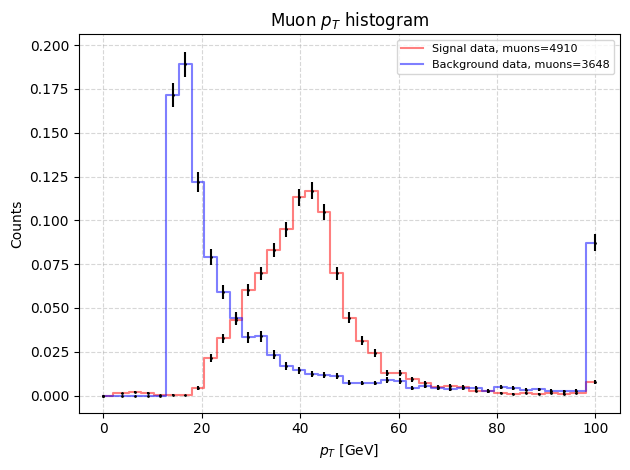

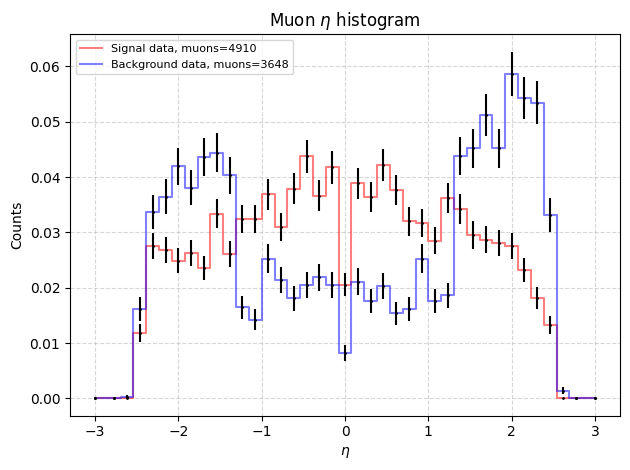

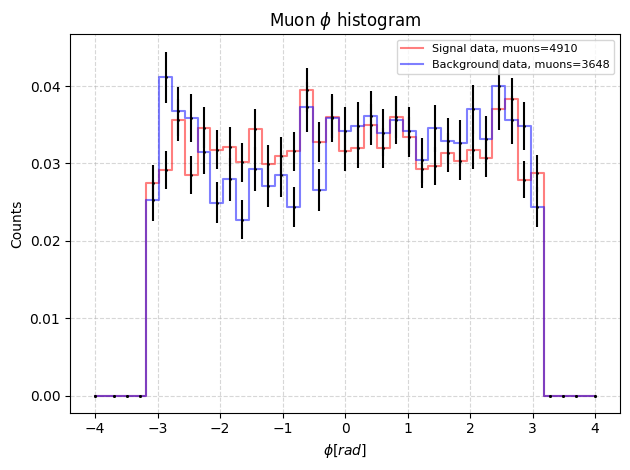

In [9]:
l1=len(ak.flatten(Zmumu_pt))
l2=len(ak.flatten(ZeroBias_pt))

coolplot([Zmumu_pt/1000, ZeroBias_pt/1000], np.linspace(0,100, 40),
          labels=[rf"Signal data, muons={l1}", 
                  f"Background data, muons={l2}"], 
                  title="Muon $p_T$ histogram", x_label=r"$p_T$ [GeV]",
                    y_label="Counts", plot_show=False, collect_overflow=True)
plt.savefig('pt_hist.pdf', format='pdf')
plt.show()
coolplot([Zmumu_eta, ZeroBias_eta], np.linspace(-3,3, 40),
         labels=[rf"Signal data, muons={l1}", f"Background data, muons={l2}"], title=r"Muon $\eta$ histogram", x_label=r"$\eta$", y_label="Counts", plot_show=False)
plt.savefig('eta_hist.pdf', format='pdf')
plt.show()
coolplot([Zmumu_phi, ZeroBias_phi], np.linspace(-4,4, 40),
          labels=[rf"Signal data, muons={l1}", f"Background data, muons={l2}"], title=r"Muon $\phi$ histogram",  x_label=r"$\phi [rad]$", y_label="Counts", plot_show=False)
plt.savefig('phi_hist.pdf', format='pdf')
plt.show()

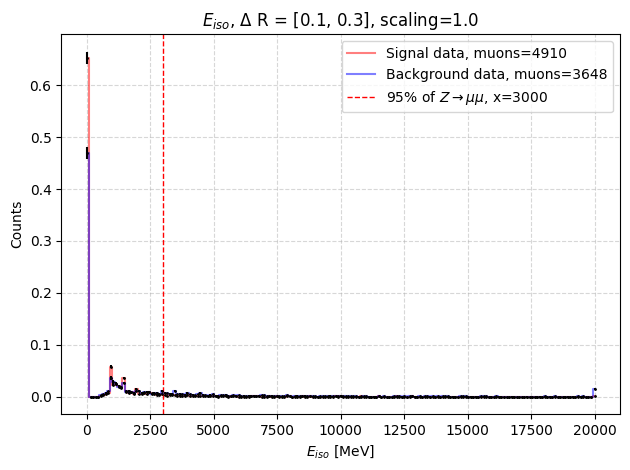

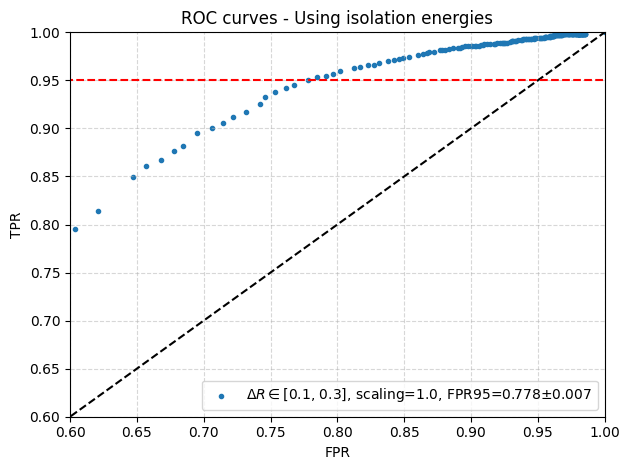

In [10]:
#Empty lists
FPRs=[]
TPRs=[]
FPR95s=[]
errs=[]
#Steps of 500 MeV due to calorimeter granularities7
xmin=0
xmax=20000
steps=int((xmax-xmin)/100)
bins=np.linspace(xmin, xmax, steps)

#######################################################################################################################################
#Define fundamental parameters such as dr range and scaling ###########################################################################
dr_mins=[0.1]
dr_maxs=[0.3]
scaling=1.0
#######################################################################################################################################

for i in range(len(dr_mins)):
    #Get i-th parameters
    dr_min=dr_mins[i]
    dr_max=dr_maxs[i]

    #Compute i-th muon isolation
    res1=muon_isolation_all_events(MuonTree_Zmumu, Zmumu_eta, Zmumu_phi, dr_min, dr_max,
                                    event_range=[nmin1, nmax1], scaling=scaling)
    res2=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, 
                                event_range=[0, len(ZeroBias_eta)], scaling=scaling)

    #Obtain the position of the percentile 90%
    zmumu_95 = np.percentile(ak.flatten(res1), 95)

    #Obtain number of muons 
    l3=len(ak.flatten(res1))
    l4=len(ak.flatten(res2))

    #Plot + get bins that will be used later for the ROC curve
    roc_bins=coolplot([res1, res2],bins, plot_show=False, x_label=r"$E_{iso}$ [MeV]",
        y_label="Counts", title=fr"$E_{{iso}}$, $\Delta$ R = [{dr_min}, {dr_max}], scaling={scaling}",
        labels=[rf"Signal data, muons={l3}", rf"Background data, muons={l4}"])
    
    #Plot vertical line located at percentile 95%
    plt.axvline(x=zmumu_95, color='r', linestyle='--', linewidth=1, label=rf"95% of $Z\to\mu\mu$, x={int(zmumu_95)}")
    plt.legend()  # Add the legend first

    #Save figure
    filename = f"iso_{dr_min}_{dr_max}_scaling_{scaling}.pdf"
    plt.savefig(filename)  
    plt.show() 

    Zmumu_counts, _ = np.histogram(ak.flatten(res1), roc_bins)
    ZeroBias_counts, _ = np.histogram(ak.flatten(res2), roc_bins)
    #Compute the cumulative sum of the counts (like integrating the histogram to the left)
    Zmumu_cumulative_counts = np.cumsum(Zmumu_counts)
    ZeroBias_cumulative_counts = np.cumsum(ZeroBias_counts)
    # Normalize to total events
    TPR = Zmumu_cumulative_counts / np.sum(Zmumu_counts)
    FPR = ZeroBias_cumulative_counts / np.sum(ZeroBias_counts)
    #Plot ROC
    FPR95=min(FPR[TPR >= 0.95])
    err=FPR_uncertainty(FPR95, len(ak.flatten(res2)))

    FPRs.append(FPR)
    TPRs.append(TPR)
    FPR95s.append(FPR95)
    errs.append(err)

for i in range(len(dr_mins)):
    plt.scatter(FPRs[i], TPRs[i], marker='.', 
                label=fr'$\Delta R \in$[{dr_mins[i]}, {dr_maxs[i]}], scaling={scaling}, FPR95={np.round(FPR95s[i],3)}$\pm${np.round(errs[i],3)}')
    plt.plot([0,1],[0,1], color='black', linestyle='--')
    plt.plot([0,1],[0.95,0.95],color='r', linestyle='--')
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.xlim(0.6, 1.0)
    plt.ylim(0.6, 1.0)
    plt.legend()
    plt.title(rf"ROC curves - Using isolation energies")
    plt.tight_layout()

filename = f"ROC_dr_min_{min(dr_mins)}_{max(dr_mins)}__dr_max_{min(dr_maxs)}_{max(dr_maxs)}_scaling_{scaling}.pdf"
plt.savefig(filename)  # Save the figure with the legend
plt.show()  # Display the figure

Step 1 out of 25


Step 2 out of 25


Step 3 out of 25


Step 4 out of 25


Step 5 out of 25


Step 6 out of 25


Step 7 out of 25


Step 8 out of 25


Step 9 out of 25


Step 10 out of 25


Step 11 out of 25
Step 12 out of 25


Step 13 out of 25


Step 14 out of 25


Step 15 out of 25


Step 16 out of 25
Step 17 out of 25


Step 18 out of 25


Step 19 out of 25


Step 20 out of 25


Step 21 out of 25
Step 22 out of 25
Step 23 out of 25


Step 24 out of 25


Step 25 out of 25


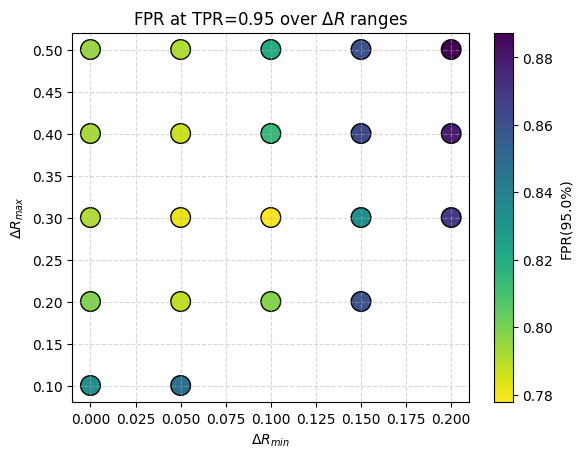

In [11]:
xmin=0
xmax=20000
steps=int((xmax-xmin)/100)
bins=np.linspace(xmin, xmax, steps)
scaling=1.0

points=5
iterations=1
next_dr_mins=np.linspace(0,0.20,points)
next_dr_maxs=np.linspace(0.10,0.5,points)

min_range=[min(next_dr_mins), max(next_dr_mins)]
max_range=[min(next_dr_maxs), max(next_dr_maxs)]

FPR_effs, dr_mins, dr_maxs= ROC_FPR_2D_plot(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                 ZeroBias_phi, [nmin1,nmax1], [0, len(ZeroBias_pt)],
                   min_range, max_range, points, bins=roc_bins, scaling=scaling, use_ratio=False, target_efficiency=0.95, plot_show=False)
plt.savefig(f'2D_ROC_dr_min_{min(dr_mins):.2f}_{max(dr_mins):.2f}_dr_max_{min(dr_maxs):.2f}_{max(dr_maxs):.2f}_scaling_{scaling:.2f}.pdf'
, format='pdf')
plt.show()